In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tensorflow.keras.models import load_model
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
from math import exp

In [2]:
# Thiết lập seed để tái lập kết quả
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class TrafficSignModel(nn.Module):
    def __init__(self):
        super(TrafficSignModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(2048, 512)  
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 43)  

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.bn1(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.bn2(x)
        
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Vẫn giữ Dropout
        x = self.fc2(x)
        return x


In [4]:
# Class FovExWrapper (giữ nguyên cấu trúc, không cần sửa)
class FovExWrapper(nn.Module):
    def __init__(self, downstream_model, criterion, target_function, image_size, foveation_sigma, blur_filter_size, blur_sigma, forgetting, heatmap_sigma, heatmap_forgetting, foveation_aggregation=1, device="cuda"):
        super(FovExWrapper, self).__init__()
        self.image_size = image_size
        self.blur_filter_size = blur_filter_size
        self.blur_sigma = blur_sigma
        self.foveation_sigma = foveation_sigma
        self.forgetting = forgetting
        self.foveation_aggregation = foveation_aggregation
        self.internal_representation = None
        self.ones = None
        self.device = device
        self.downstream_model = downstream_model
        self.criterion = criterion
        self.target_function = target_function
        self.heatmap_sigma = heatmap_sigma
        self.heatmap_forgetting = heatmap_forgetting

    def forward(self, x, foveation_positions):
        if self.internal_representation is None:
            raise Exception("First set internal representation with function: initialize_scanpath_generation()")
        foveation_area = get_foveation(self.foveation_aggregation, self.foveation_sigma, self.image_size, foveation_positions)
        current_foveation_area = self.internal_representation + foveation_area
        blurring_mask = torch.clip(self.ones - current_foveation_area, 0, 1)
        applied_blur = self.blur * blurring_mask
        output = self.downstream_model(x + applied_blur)
        return output

    def initialize_scanpath_generation(self, x, batch_size):
        self.internal_representation = torch.zeros((batch_size, 1, self.image_size, self.image_size), device=self.device)
        self.ones = torch.ones((batch_size, 1, self.image_size, self.image_size), device=self.device)
        self.blur = calculate_blur(x, self.blur_filter_size, self.blur_sigma)

    def run_optimization(self, x, labels, scanpath_length, opt_iterations, learning_rate, random_restarts=False):
        batch_size = x.size(0)
        targets = self.target_function(x, labels)
        self.initialize_scanpath_generation(x, batch_size)
        scanpath = []
        loss_history = []
        for _ in range(scanpath_length):
            foveation_pos = torch.zeros((batch_size, 2, 1, 1), device='cuda', requires_grad=True)
            best_foveation_pos = torch.zeros((batch_size, 2, 1, 1), device='cuda')
            best_loss = torch.ones((batch_size), device='cuda', dtype=torch.float32) * float("inf")
            for _ in range(opt_iterations):
                output = self(x, foveation_pos)
                loss = self.criterion(output, targets)
                total_loss = loss.mean()
                grad = torch.autograd.grad(total_loss, foveation_pos)[0]
                foveation_pos.data -= torch.sign(grad) * learning_rate
                idxs = loss < best_loss
                best_loss[idxs] = loss[idxs]
                best_foveation_pos[idxs] = foveation_pos[idxs]
                if torch.sum(~idxs) > 0:
                    if random_restarts:
                        foveation_pos.data[~idxs] = torch.rand_like(best_foveation_pos.data[~idxs]) * 2 - 1
                    else:
                        foveation_pos.data[~idxs] += torch.rand_like(best_foveation_pos.data[~idxs]) * learning_rate - learning_rate / 2
            current_foveation_mask = get_foveation(self.foveation_aggregation, self.foveation_sigma, self.image_size, best_foveation_pos)
            self.internal_representation = (self.internal_representation * self.forgetting + current_foveation_mask).detach()
            scanpath.append(best_foveation_pos.detach())
            loss_history.append(loss.detach())
        return torch.stack(scanpath, 1).squeeze(), torch.stack(loss_history, 1).squeeze(), self.internal_representation

    def generate_explanation(self, x, labels, scanpath_length, opt_iterations, learning_rate, random_restarts=False, normalize_heatmap=True, seed=42):   
        set_seed(seed)   
        current_scanpaths, current_loss_history, internal_rep = self.run_optimization(x, labels, scanpath_length, opt_iterations, learning_rate, random_restarts)
        heatmap = get_heat_maps(self.heatmap_sigma, self.image_size, current_scanpaths[None], self.heatmap_forgetting, self.device, normalize_heatmap)
        return heatmap, current_scanpaths, current_loss_history, internal_rep

In [5]:
# Các hàm hỗ trợ của FovEx (giữ nguyên)
def calc_gaussian(a, std_dev, image_size, positions):
    B = positions.shape[0]
    xa, ya = create_grid(B, image_size)
    xa = xa - positions[:, 0]
    ya = ya - positions[:, 1]
    distance = (xa**2 + ya**2)
    g = a * torch.exp(-distance / std_dev)
    return g.view(B, 1, image_size, image_size)

def create_grid(batch_size, size):
    t = torch.linspace(-1, 1, size).cuda()
    xa, ya = torch.meshgrid([t, t])
    xa = xa.view(1, size, size).repeat(batch_size, 1, 1)
    ya = ya.view(1, size, size).repeat(batch_size, 1, 1)
    return xa, ya

def calculate_blur(images, blur_filter_size, sigma=5):
    def gaussian(window_size, sigma):
        gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
        return gauss / gauss.sum()
    def create_window(window_size, channel, sigma):
        _1D_window = gaussian(window_size, sigma).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
        return window
    window = create_window(blur_filter_size, images.shape[1], sigma).cuda()
    pad = nn.ReflectionPad2d(padding=blur_filter_size // 2)
    imgs_pad = pad(images)
    blured_images = F.conv2d(imgs_pad, window, groups=images.shape[1])
    blur = blured_images - images
    return blur

def get_foveation(foveation_aggregation, foveation_sigma, image_size, positions):
    mask = calc_gaussian(foveation_aggregation, foveation_sigma, image_size, positions)
    return mask

def normalize(x):
    x = (x - x.min()) / (x.max() - x.min() + 1e-10)
    return x

def get_heat_maps(foveation_sigma, image_size, scanpaths, forgetting_factor, device, normalization):
    batch_size = scanpaths.shape[0]
    heat_map = torch.zeros((batch_size, 1, image_size, image_size)).to(device)
    for i in range(scanpaths.shape[1]):
        current_foveation_mask = get_foveation(1, foveation_sigma, image_size, scanpaths[:, i, :, None, None])
        heat_map = forgetting_factor[i] * heat_map + current_foveation_mask
    if normalization:
        heat_map = normalize(heat_map)
    return heat_map

In [6]:
import torch
from tensorflow.keras.models import load_model

def load_keras_weights_to_pytorch(pytorch_model, keras_model_path):
    keras_model = load_model(keras_model_path)
    keras_weights = keras_model.get_weights()
    state_dict = pytorch_model.state_dict()
    
    weight_map = [
        ('conv1.weight', 0, lambda w: torch.tensor(w.transpose(3, 2, 0, 1))),
        ('conv1.bias', 1, torch.tensor),
        ('conv2.weight', 2, lambda w: torch.tensor(w.transpose(3, 2, 0, 1))),
        ('conv2.bias', 3, torch.tensor),
        ('conv3.weight', 8, lambda w: torch.tensor(w.transpose(3, 2, 0, 1))),
        ('conv3.bias', 9, torch.tensor),
        ('conv4.weight', 10, lambda w: torch.tensor(w.transpose(3, 2, 0, 1))),
        ('conv4.bias', 11, torch.tensor),
        ('fc1.weight', 16, lambda w: torch.tensor(w.T)),
        ('fc1.bias', 17, torch.tensor),
        ('fc2.weight', 22, lambda w: torch.tensor(w.T)),
        ('fc2.bias', 23, torch.tensor),
    ]
    
    for (name, idx, transform) in weight_map:
        weight_tensor = transform(keras_weights[idx])
        
        if name == "fc1.weight":
            pytorch_shape = state_dict[name].shape  # (512, 3200) trong PyTorch
            keras_shape = weight_tensor.shape  # (512, 2048) trong Keras
            
            if keras_shape[1] != pytorch_shape[1]:
                print(f"⚠️ Kích thước fc1.weight không khớp: {keras_shape} -> {pytorch_shape}")

                # Sử dụng phép nội suy thay vì padding/cắt trực tiếp
                scale_factor = pytorch_shape[1] / keras_shape[1]
                weight_tensor = torch.nn.functional.interpolate(
                    weight_tensor.unsqueeze(0).unsqueeze(0), 
                    size=(weight_tensor.shape[0], pytorch_shape[1]), 
                    mode="bilinear", align_corners=False
                ).squeeze(0).squeeze(0)

            print(f"✅ Cập nhật fc1.weight: {keras_shape} -> {weight_tensor.shape}")

        
        state_dict[name] = weight_tensor
    
    pytorch_model.load_state_dict(state_dict)
    return pytorch_model

In [7]:
# Định nghĩa các lớp biển báo
classes = { 0:'Speed limit (20km/h)', 1:'Speed limit (30km/h)', 2:'Speed limit (50km/h)', 3:'Speed limit (60km/h)', 
           4:'Speed limit (70km/h)', 5:'Speed limit (80km/h)', 6:'End of speed limit (80km/h)', 7:'Speed limit (100km/h)', 
           8:'Speed limit (120km/h)', 9:'No passing', 10:'No passing veh over 3.5 tons', 11:'Right-of-way at intersection', 
           12:'Priority road', 13:'Yield', 14:'Stop', 15:'No vehicles', 16:'Veh > 3.5 tons prohibited', 17:'No entry', 
           18:'General caution', 19:'Dangerous curve left', 20:'Dangerous curve right', 21:'Double curve', 22:'Bumpy road', 
           23:'Slippery road', 24:'Road narrows on the right', 25:'Road work', 26:'Traffic signals', 27:'Pedestrians', 
           28:'Children crossing', 29:'Bicycles crossing', 30:'Beware of ice/snow', 31:'Wild animals crossing', 
           32:'End speed + passing limits', 33:'Turn right ahead', 34:'Turn left ahead', 35:'Ahead only', 
           36:'Go straight or right', 37:'Go straight or left', 38:'Keep right', 39:'Keep left', 40:'Roundabout mandatory', 
           41:'End of no passing', 42:'End no passing veh > 3.5 tons' }

In [8]:
# Đường dẫn và khởi tạo mô hình
model_path = "D:/HUS_22001541/PPNCKH/TrafficSign_Recognition/output/traffic_sign_model_trained.h5"
img_path = "D:/HUS_22001541/PPNCKH/TrafficSign_Recognition/input/Test/00284.png"  

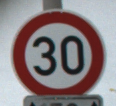

In [9]:
# Hiển thị ảnh gốc
pil_img = Image.open(img_path)
display(pil_img)

In [10]:
# Tải và xử lý ảnh
test_image = cv2.imread(img_path)
if test_image is None:
    print("Lỗi: Không thể tải ảnh từ", img_path)
    exit()
traffic_img = cv2.resize(test_image, (30, 30), interpolation=cv2.INTER_AREA)
traffic_image_array = np.array(traffic_img, dtype=np.float32) / 255.0
traffic_input = torch.tensor(traffic_image_array).permute(2, 0, 1).unsqueeze(0).cuda()  # [1, 3, 30, 30]

In [11]:
# Khởi tạo và tải trọng số cho mô hình PyTorch
downstream_model = TrafficSignModel().cuda()
downstream_model = load_keras_weights_to_pytorch(downstream_model, model_path)

✅ Cập nhật fc1.weight: torch.Size([512, 2048]) -> torch.Size([512, 2048])


In [12]:
# Chuyển mô hình sang chế độ đánh giá
# downstream_model.eval()

# Dự đoán biển báo
with torch.no_grad():
    pred = downstream_model(traffic_input)
    pred_label = torch.argmax(pred, dim=1)
    output_traffic_sign = classes[pred_label.item()]
    print(f"Dự đoán biển báo: {output_traffic_sign}")


Dự đoán biển báo: No passing veh over 3.5 tons


In [13]:
traffic_input.shape[1]

3

In [14]:
# Khởi tạo FovExWrapper
criterion = nn.CrossEntropyLoss(reduction='none')
target_function = lambda x, y: y
fovex = FovExWrapper(
    downstream_model=downstream_model,
    criterion=criterion,
    target_function=target_function,
    image_size=30,
    foveation_sigma=0.2,
    blur_filter_size=11,
    blur_sigma=5,
    forgetting=0.9,
    heatmap_sigma=0.1,
    heatmap_forgetting=[0.9] * 5,
    device="cuda"
)

# Tạo heatmap bằng FovEx
heatmap, scanpaths, loss_history, internal_rep = fovex.generate_explanation(
    x=traffic_input,
    labels=pred_label,
    scanpath_length=5,
    opt_iterations=50,
    learning_rate=0.1,
    random_restarts=False,
    normalize_heatmap=True
)

# Phóng to heatmap về kích thước gốc
original_height, original_width = test_image.shape[:2]
heatmap_resized = F.interpolate(heatmap, size=(original_height, original_width), mode='bilinear', align_corners=False)
heatmap_np = heatmap_resized.squeeze().cpu().numpy()

# Chuẩn hóa và áp dụng colormap
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_np), cv2.COLORMAP_JET)

# Chồng heatmap lên ảnh gốc
superimposed_img = heatmap_color * 0.4 + test_image
superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

Random seed set as 42


c:\Users\Admin\anaconda3\envs\py310\lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


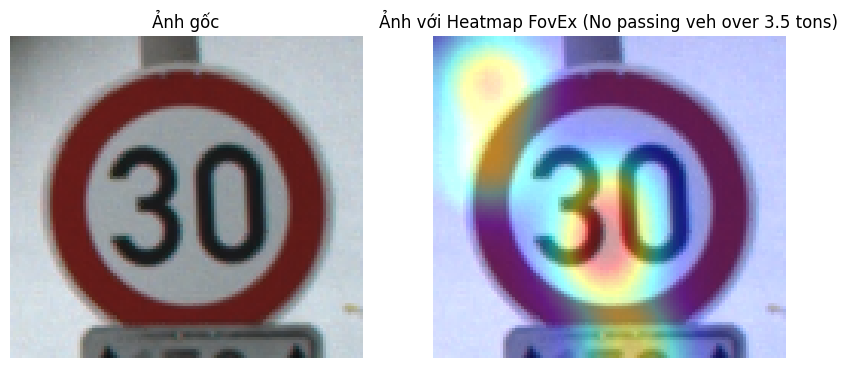

In [15]:
# Hiển thị kết quả
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.title("Ảnh gốc")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f"Ảnh với Heatmap FovEx ({output_traffic_sign})")
plt.axis('off')
plt.show()